In [1]:
import cplex
import pandas as pd
from scipy.spatial.distance import cityblock

In [2]:
location_list = []

Let's create a class for the locations, so we can easily define the nodes.

In [3]:
class location:  # define a class to generate location objects
    def __init__(self, id, index, demand):  # constructor, initiates a location object
        self.id = id
        self.index = index
        self.distance = {} # dictionary to keep the distance values to other locations
        self.demand = demand # demand of each location

    def __str__(self):  # if we try to print a vertex object, this function returns the id (string)
        return self.id


Then, we can create another method to construct location objects (nodes), and assigne their demands and distances to another locations. The parameters are basically the input data.

In [4]:
def create_graph(locations, demands):  # to create locations, assigning demands and distances

    global location_list
    locations.append(locations[0])  # to create a dummy return depot (n+1)
    demands.append(demands[0])
    for i in range(len(locations)):
        location_list.append(location(id="l_" + str(i), index=i, demand=demands[i])) # creating the locations

    for i in location_list:
        for j in location_list:
            i.distance[j] = float(cityblock(locations[i.index], locations[j.index]))
            # cityblock function returns the manhattan distance between two vectors

Let's create another function to print the solution of a model.

In [5]:
def print_solution(cpx): # a function to evaluate and print the solution of a model
    cpx.solve()
    print()
    print("Solution status = ", cpx.solution.get_status(), ":", end=' ')
    print(cpx.solution.status[cpx.solution.get_status()])
    print("Solution value  = ", cpx.solution.get_objective_value())
    print()
    
    solution_x, solution_y=[], {}
    
    for i in location_list:
        for j in location_list:
            if j.index != i.index:
                if cpx.solution.get_values(x[i.index][j.index]) > 0 :
                    solution_x.append([i.index, j.index, i.distance[j]])
        
        solution_y[i.index] = round(cpx.solution.get_values(y[i.index]), 0)
        # values of the decision variables y (load of the vehicle)     
        
    starter, follower=[] , [] # find the starting locations of the routes
    for i in range(len(solution_x)):
        if solution_x[i][0]==0:
            starter.append([solution_x[i][0], solution_x[i][1],solution_x[i][2]])
        else:
            follower.append([solution_x[i][0], solution_x[i][1], solution_x[i][2]])
            
    
    routes, route_length = [], [] # find the routes and their lengths
    for i in range(len(starter)):
        to_go = starter[i][1] # starting from a location which is first visited by a vehicle from the depot,
        current_route = [starter[i][0], to_go] # create a route,
        current_length = starter[i][2] # sum the distances between the traversed locations,
        while to_go != location_list[-1].index: # until the route is completed in the depot
            for j in range(len(follower)):
                if follower[j][0] == to_go:
                    current_route.append(follower[j][1])
                    current_length += follower[j][2]
                    to_go = follower[j][1]
        routes.extend([current_route])
        route_length.append(current_length)

    # print the routes of the vehicles and the total load of a vehicle after visiting a specific location
    for i in range(len(routes)):
        print("Route for vehicle " + str(i + 1))
        for j in range(len(routes[i]) - 1):
            print(str(routes[i][j]) + " load: (" + str(solution_y[routes[i][j]]) + ") --> ", end=' ')
        print("0") # 0 presents the return here
        print("Route length: " + str(route_length[i]))
        print()

Then, we can start by reading the input file and constructing the location instances.

In [6]:
if __name__ == "__main__":
    data_locations = pd.read_excel("CVRP_input.xlsx", sheet_name="locations", index_col=0)
    locations = data_locations.values.tolist()
    data_demands = pd.read_excel("CVRP_input.xlsx", sheet_name="demands", index_col=0)
    demands = data_demands.values.tolist()
    capacity = 15 # max capacity of each vehicle
    vehicles = 4 # number of vehicles
    create_graph(locations, demands) # call the function to create the locations


After that, we can start to construct the model. Since we may need to limit the runtime of our computational experiments especially for large-scaled MIPs, we can set a time limit for the model to run. After the time limit has been reached, the model will return the best solution found.

In [7]:
cpx=cplex.Cplex()
cpx.parameters.timelimit.set(225.0) # you can set the time limit in seconds
cpx.objective.set_sense(cpx.objective.sense.minimize)

Define the decision variables.

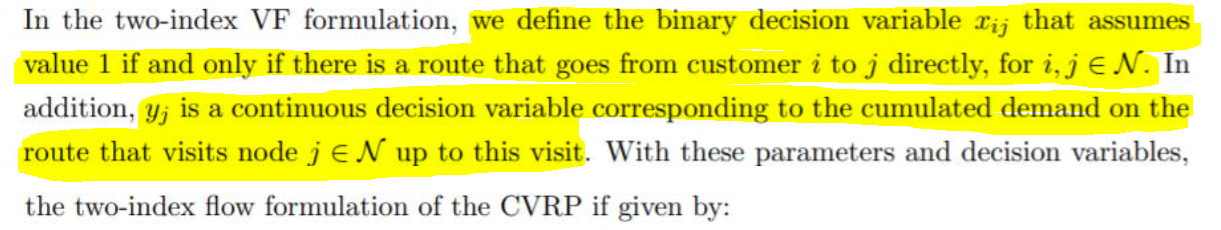
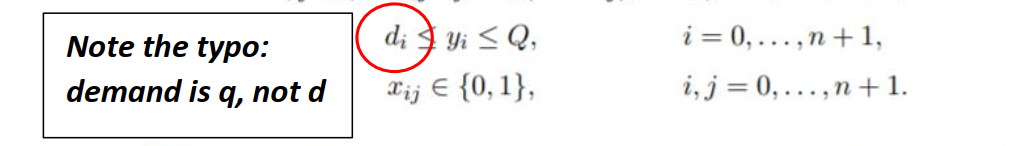

In [8]:
x = {i:{j: "x_" + str(i) + "_" + str(j) for j in range(len(location_list))} for i in range(len(location_list))}

y = {i:"y_" + str(i) for i in range(len(location_list))}

for i in location_list:
    for j in location_list:
        if j.index != i.index:
            cpx.variables.add(obj=[i.distance[j]], types=["B"], names=[x[i.index][j.index]])

for i in location_list:
    cpx.variables.add(lb=[i.demand[0]], ub=[capacity], types=["C"], names=[y[i.index]])
     # note that y variables are continuous
     # demand[0] is the demand for that location
    # demand[0] is calling the only element of the attr demand as number

Add the constraints to the model.

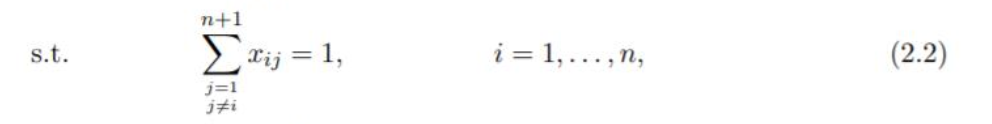

In [9]:
for i in location_list:
    if i.index != 0 and i.index != len(location_list) - 1:
        coef_1, var_1=[], []
        for j in location_list:
            if j.index != i.index and j.index != 0:
                coef_1.append(1)
                var_1.append(x[i.index][j.index])
        cpx.linear_constraints.add(lin_expr=[[var_1,coef_1]], senses=["E"], rhs=[1])

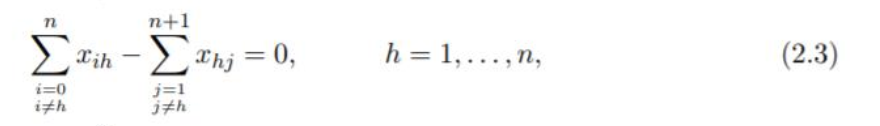

In [10]:
for h in location_list: # constraints 2 (2.3)
    if h.index != 0 and h.index != len(location_list) - 1:
        coef_2, var_2 = [], []
        for i in location_list:
            if i.index != len(location_list) - 1 and i is not h:
                coef_2.append(1)
                var_2.append(x[i.index][h.index])
        for j in location_list:
            if j.index != 0 and j is not h:
                coef_2.append(-1)
                var_2.append(x[h.index][j.index])
        cpx.linear_constraints.add(lin_expr=[[var_2, coef_2]], senses=["E"], rhs=[0])


In [11]:
print(location_list[9].demand)

[1]


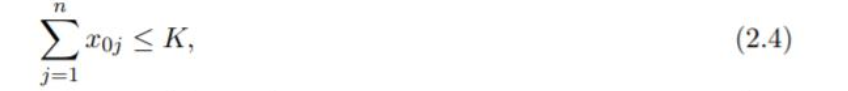

In [12]:
coef_3, var_3 = [], [] # constraints 3 (2.4)
for j in location_list:
    if j.index != 0 and j.index != len(location_list)-1:
        coef_3.append(1)
        var_3.append(x[0][j.index])
cpx.linear_constraints.add(lin_expr=[[var_3, coef_3]],senses=["L"],rhs=[vehicles])

range(32, 33)

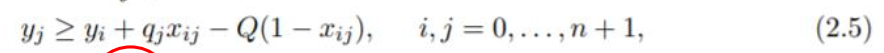

In [13]:
for i in location_list: 
    for j in location_list:
        if j.index != i.index:
            coef_4 = [1, -1, -j.demand[0] - capacity]
            var_4 = [y[j.index], y[i.index], x[i.index][j.index]]
            cpx.linear_constraints.add(lin_expr=[[var_4, coef_4]], senses=["G"],
                                       rhs=[-capacity])

In [14]:
print_solution(cpx)

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               225
Tried aggregator 1 time.
MIP Presolve eliminated 78 rows and 48 columns.
MIP Presolve modified 732 coefficients.
Reduced MIP has 261 rows, 276 columns, and 1188 nonzeros.
Reduced MIP has 260 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.16 sec. (1.17 ticks)
Probing time = 0.00 sec. (0.93 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 261 rows, 276 columns, and 1188 nonzeros.
Reduced MIP has 260 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.94 ticks)
Clique table members: 434.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.08 sec. (0.50 ticks)

        Nodes                                        